# VIT2GPT
__Author__ : Reza Mousavi 400222100 ,Mohammad Rouintan 400222042

__Course__ : Undergraduate Applied Data Mining Course

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/raddar/chest-xrays-indiana-university/data?select=indiana_projections.csv")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rezamousavi8740
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/raddar/chest-xrays-indiana-university


100%|██████████| 13.2G/13.2G [11:24<00:00, 20.6MB/s]


In [ ]:
import pandas as pd
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

In [ ]:
firstCSV = pd.read_csv("/content/chest-xrays-indiana-university/indiana_projections.csv")
firstCSV

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal
...,...,...,...
7461,3997,3997_IM-2048-1002.dcm.png,Lateral
7462,3998,3998_IM-2048-1001.dcm.png,Frontal
7463,3998,3998_IM-2048-1002.dcm.png,Lateral
7464,3999,3999_IM-2049-1001.dcm.png,Frontal


In [ ]:
secCSV = pd.read_csv("/content/chest-xrays-indiana-university/indiana_reports.csv")
secCSV

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
...,...,...,...,...,...,...,...,...
3846,3995,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.","XXXX, XXXX.",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...
3847,3996,Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...
3848,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB."
3849,3998,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,NaN,Heart size is normal and the lungs are clear.


In [ ]:
image_column = "filename"
uid_column = "uid"
output_file = "/content/drive/MyDrive/dataMIN/CILP_embeddings.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_name = "openai/clip-vit-base-patch16"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [ ]:
embeddings_list = []

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
model = model.to(device)

for index, row in tqdm(firstCSV.iterrows(), total=firstCSV.shape[0], desc="Processing Images"):
    image_path = "/content/chest-xrays-indiana-university/images/images_normalized/" + row[image_column]
    uid = row[uid_column]

    try:
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model.get_image_features(image_tensor)

        embedding = outputs.cpu().numpy().flatten()

        embeddings_list.append({
            "uid": uid,
            "image_path": image_path,
            "embedding": embedding.tolist()
        })

    except Exception as e:
        print(f"ERROR: {image_path}: {e}")

Processing Images: 100%|██████████| 7466/7466 [12:50<00:00,  9.69it/s]


In [ ]:
embeddings_df = pd.DataFrame(embeddings_list)
embeddings_df.to_csv(output_file, index=False)

print(f"Embedding‌ Saved on: {output_file}")

Embedding‌ Saved on: /content/drive/MyDrive/dataMIN/CILP_embeddings.csv


In [ ]:
embeddings_df

,uid,image_path,embedding
0,1,/content/chest-xrays-indiana-university/images...,"[-0.2574523389339447, 0.1063101589679718, -0.3..."
1,1,/content/chest-xrays-indiana-university/images...,"[-0.215048685669899, 0.1469147801399231, -0.30..."
2,2,/content/chest-xrays-indiana-university/images...,"[-0.28959643840789795, 0.05896506458520889, -0..."
3,2,/content/chest-xrays-indiana-university/images...,"[0.01664716750383377, 0.03293318673968315, -0...."
4,3,/content/chest-xrays-indiana-university/images...,"[-0.3081686198711395, 0.10432203859090805, -0...."
...,...,...,...
7461,3997,/content/chest-xrays-indiana-university/images...,"[-0.18496036529541016, 0.17296871542930603, -0..."
7462,3998,/content/chest-xrays-indiana-university/images...,"[-0.3399403691291809, 0.20170554518699646, -0...."
7463,3998,/content/chest-xrays-indiana-university/images...,"[-0.09155020862817764, 0.1952713280916214, -0...."
7464,3999,/content/chest-xrays-indiana-university/images...,"[-0.31117764115333557, 0.20649202167987823, -0..."


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embeddings_df = pd.read_csv("/content/drive/MyDrive/dataMIN/CILP_embeddings.csv")
embeddings_df

,uid,image_path,embedding
0,1,/content/chest-xrays-indiana-university/images...,"[-0.2574523389339447, 0.1063101589679718, -0.3..."
1,1,/content/chest-xrays-indiana-university/images...,"[-0.215048685669899, 0.1469147801399231, -0.30..."
2,2,/content/chest-xrays-indiana-university/images...,"[-0.28959643840789795, 0.05896506458520889, -0..."
3,2,/content/chest-xrays-indiana-university/images...,"[0.01664716750383377, 0.03293318673968315, -0...."
4,3,/content/chest-xrays-indiana-university/images...,"[-0.3081686198711395, 0.10432203859090805, -0...."
...,...,...,...
7461,3997,/content/chest-xrays-indiana-university/images...,"[-0.18496036529541016, 0.17296871542930603, -0..."
7462,3998,/content/chest-xrays-indiana-university/images...,"[-0.3399403691291809, 0.20170554518699646, -0...."
7463,3998,/content/chest-xrays-indiana-university/images...,"[-0.09155020862817764, 0.1952713280916214, -0...."
7464,3999,/content/chest-xrays-indiana-university/images...,"[-0.31117764115333557, 0.20649202167987823, -0..."


In the initial phase of the data mining course project, the primary objective is to establish a connection between a Vision Transformer (VIT) model and a Generative Pre-trained Transformer (GPT) model. This integration aims to enable the model to generate descriptive and diagnostic outputs, akin to a medical professional, when provided with an X-ray image. To achieve this, the first critical step involves transforming each X-ray image into an appropriate embedding space that is compatible with the GPT model.

Theoretically, the optimal approach would involve designing a dedicated VIT encoder model and subsequently transferring its outputs to a GPT decoder. However, this method is not feasible due to practical constraints. Instead, the most effective strategy is to utilize a pre-trained model capable of converting each image into a suitable latent representation. This pre-trained model must be specifically trained on X-ray images to ensure that the transformation is both accurate and relevant to the medical domain.

For this purpose, the project employs the CLIP (Contrastive Language–Image Pretraining) model, which has been pre-trained on a dataset that includes medical images. The CLIP model is particularly advantageous as it is designed to understand and correlate visual and textual information, making it well-suited for generating descriptive outputs based on visual inputs. By leveraging the CLIP model, the project ensures that the X-ray images are effectively mapped into a latent space that can be seamlessly integrated with the GPT model, thereby facilitating the generation of coherent and contextually appropriate medical descriptions and diagnoses.

In [ ]:
import ast

class MedicalDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.embeddings = dataframe["embedding"].values
        self.texts = dataframe["findings"].values
        self.image_paths = dataframe["image_path"].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      embedding = self.embeddings[idx]

      if isinstance(embedding, str):
          embedding = ast.literal_eval(embedding)  # Safely evaluate the string as a list

      return {
          "embedding": torch.tensor(embedding, dtype=torch.float32),
          "text": self.texts[idx],
          "image_path": self.image_paths[idx]
      }

In [ ]:
output_dir = "/content/drive/MyDrive/dataMIN/model_checkpoints"
os.makedirs(output_dir, exist_ok=True)

def calculate_bleu(reference, hypothesis):
    ref = [reference.split()]
    hyp = hypothesis.split()
    return sentence_bleu(ref, hyp)


In [ ]:
def save_checkpoint(model, optimizer, epoch, step, avg_loss, avg_bleu):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "step": step,
        "avg_loss": avg_loss,
        "avg_bleu": avg_bleu
    }
    save_path = os.path.join(output_dir, f"checkpoint_epoch{epoch}_step{step}.pth")
    torch.save(checkpoint, save_path)
    print(f"Checkpoint saved at {save_path}")

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

embedding_size = 512
gpt2_embedding_size = model.config.n_embd

tokenizer.pad_token = tokenizer.eos_token

if embedding_size != gpt2_embedding_size:
    mlp = nn.Sequential(
        nn.Linear(embedding_size, gpt2_embedding_size),
        nn.ReLU()
    ).to(device)
else:
    mlp = nn.Identity().to(device)

In [ ]:
csv_path = "/content/drive/MyDrive/dataMIN/indiana_reports.csv"
data_df = pd.read_csv(csv_path)

csv_embeddings = "/content/drive/MyDrive/dataMIN/CILP_embeddings.csv"

In [ ]:
merged_df = pd.merge(embeddings_df, data_df, on="uid", how="inner")
merged_df = merged_df.dropna(subset=['findings'])
merged_df

,uid,image_path,embedding,MeSH,Problems,image,indication,comparison,findings,impression
0,1,/content/chest-xrays-indiana-university/images...,"[-0.2574523389339447, 0.1063101589679718, -0.3...",normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,1,/content/chest-xrays-indiana-university/images...,"[-0.215048685669899, 0.1469147801399231, -0.30...",normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,2,/content/chest-xrays-indiana-university/images...,"[-0.28959643840789795, 0.05896506458520889, -0...",Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
3,2,/content/chest-xrays-indiana-university/images...,"[0.01664716750383377, 0.03293318673968315, -0....",Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
6,4,/content/chest-xrays-indiana-university/images...,"[-0.5415536165237427, 0.23562251031398773, -0....","Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
...,...,...,...,...,...,...,...,...,...,...
7457,3995,/content/chest-xrays-indiana-university/images...,"[-0.22564426064491272, 0.039989158511161804, -...",Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.","XXXX, XXXX.",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...
7458,3996,/content/chest-xrays-indiana-university/images...,"[-0.5196436643600464, 0.09756353497505188, -0....",Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...
7459,3996,/content/chest-xrays-indiana-university/images...,"[-0.1490238457918167, 0.10322834551334381, -0....",Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...
7460,3997,/content/chest-xrays-indiana-university/images...,"[-0.4133310317993164, 0.18901602923870087, -0....",Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB."


In [ ]:
merged_df["findings"][0]

'The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.'

In [ ]:
dataset = MedicalDataset(merged_df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
print(type(merged_df["embedding"].iloc[0]))

<class 'str'>


In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')

def calculate_bleu_score(predictions, references):
    return sentence_bleu(references, predictions)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import torch
from tqdm import tqdm
import os

def evaluate(model, dataloader, tokenizer, device):
    model.eval()
    total_loss = 0
    total_bleu_score = 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Evaluating")):
            texts = batch['text']

            inputs = tokenizer(
                texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(device)

            input_ids = inputs['input_ids']
            attention_mask = inputs['attention_mask']

            outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            total_loss += loss.item()

            predictions = tokenizer.decode(input_ids[0], skip_special_tokens=True).split()
            references = [text.split() for text in texts]
            bleu_score = calculate_bleu_score(predictions, references[0])
            total_bleu_score += bleu_score

    avg_loss = total_loss / len(dataloader)
    avg_bleu_score = total_bleu_score / len(dataloader)
    print(f"Test Loss: {avg_loss:.4f}, Average BLEU: {avg_bleu_score:.4f}")
    return avg_loss, avg_bleu_score

def calculate_bleu_score(references, predictions):
    return sentence_bleu(references, predictions)

def train(model, mlp, dataloader, optimizer, criterion, epoch, save_dir, tokenizer, device, test_loader=None):
    model.train()
    total_loss = 0
    total_bleu_score = 0

    for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True)):
        texts = batch['text']

        inputs = tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = tokenizer.decode(input_ids[0], skip_special_tokens=True).split()
        references = [text.split() for text in texts]
        bleu_score = calculate_bleu_score(predictions, references[0])
        total_bleu_score += bleu_score

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}")#, BLEU: {bleu_score:.4f}

    avg_loss = total_loss / len(dataloader)
    avg_bleu_score = total_bleu_score / len(dataloader)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}, Average BLEU: {avg_bleu_score:.4f}")#

    if test_loader:
        test_loss = evaluate(model, test_loader, tokenizer, device)

    checkpoint_path = os.path.join(save_dir, "checkpoint_latest.pth")
    torch.save({
      'epoch': epoch + 1,
      'model_state_dict': model.state_dict(),
      'mlp_state_dict': mlp.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': avg_loss,
      'bleu_score': avg_bleu_score
    }, checkpoint_path)

def calculate_bleu_score(prediction, reference):
    return sentence_bleu([reference], prediction)

In [ ]:
num_epochs = 5

optimizer = AdamW(list(model.parameters()) + list(mlp.parameters()), lr=5e-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    train(model, mlp, train_loader, optimizer, criterion, epoch, output_dir, tokenizer=tokenizer, device=device ,test_loader=test_loader)

Epoch 1/5:   0%|          | 2/647 [00:01<05:15,  2.04it/s]

Epoch 1, Batch 0/647, Loss: 6.1921


Epoch 1/5:  16%|█▌        | 101/647 [00:27<02:54,  3.12it/s]

Epoch 1, Batch 100/647, Loss: 1.2171


Epoch 1/5:  31%|███       | 202/647 [00:53<01:34,  4.70it/s]

Epoch 1, Batch 200/647, Loss: 0.9981


Epoch 1/5:  47%|████▋     | 301/647 [01:17<01:07,  5.11it/s]

Epoch 1, Batch 300/647, Loss: 0.5826


Epoch 1/5:  62%|██████▏   | 401/647 [01:41<00:58,  4.23it/s]

Epoch 1, Batch 400/647, Loss: 0.8295


Epoch 1/5:  78%|███████▊  | 502/647 [02:05<00:31,  4.54it/s]

Epoch 1, Batch 500/647, Loss: 1.4004


Epoch 1/5:  93%|█████████▎| 601/647 [02:29<00:09,  4.84it/s]

Epoch 1, Batch 600/647, Loss: 0.7513


Epoch 1/5: 100%|██████████| 647/647 [02:40<00:00,  4.03it/s]


Epoch 1, Average Loss: 1.0192, Average BLEU: 1.0000


Evaluating: 100%|██████████| 162/162 [00:12<00:00, 13.42it/s]


Test Loss: 0.7212, Average BLEU: 1.0000


Epoch 2/5:   0%|          | 2/647 [00:00<02:14,  4.80it/s]

Epoch 2, Batch 0/647, Loss: 0.6786


Epoch 2/5:  16%|█▌        | 101/647 [00:26<02:13,  4.09it/s]

Epoch 2, Batch 100/647, Loss: 0.6862


Epoch 2/5:  31%|███       | 202/647 [00:52<01:37,  4.54it/s]

Epoch 2, Batch 200/647, Loss: 0.7100


Epoch 2/5:  47%|████▋     | 301/647 [01:15<01:07,  5.12it/s]

Epoch 2, Batch 300/647, Loss: 0.3597


Epoch 2/5:  62%|██████▏   | 401/647 [01:39<00:55,  4.46it/s]

Epoch 2, Batch 400/647, Loss: 0.6649


Epoch 2/5:  78%|███████▊  | 502/647 [02:03<00:34,  4.18it/s]

Epoch 2, Batch 500/647, Loss: 1.1613


Epoch 2/5:  93%|█████████▎| 601/647 [02:28<00:09,  4.71it/s]

Epoch 2, Batch 600/647, Loss: 0.6296


Epoch 2/5: 100%|██████████| 647/647 [02:38<00:00,  4.07it/s]


Epoch 2, Average Loss: 0.6839, Average BLEU: 1.0000


Evaluating: 100%|██████████| 162/162 [00:12<00:00, 12.92it/s]


Test Loss: 0.6093, Average BLEU: 1.0000


Epoch 3/5:   0%|          | 2/647 [00:00<02:29,  4.30it/s]

Epoch 3, Batch 0/647, Loss: 0.5393


Epoch 3/5:  16%|█▌        | 102/647 [00:25<02:06,  4.30it/s]

Epoch 3, Batch 100/647, Loss: 0.5596


Epoch 3/5:  31%|███       | 202/647 [00:51<01:34,  4.72it/s]

Epoch 3, Batch 200/647, Loss: 0.5793


Epoch 3/5:  47%|████▋     | 301/647 [01:15<01:13,  4.71it/s]

Epoch 3, Batch 300/647, Loss: 0.3068


Epoch 3/5:  62%|██████▏   | 401/647 [01:39<01:19,  3.10it/s]

Epoch 3, Batch 400/647, Loss: 0.5238


Epoch 3/5:  78%|███████▊  | 502/647 [02:03<00:32,  4.52it/s]

Epoch 3, Batch 500/647, Loss: 1.0106


Epoch 3/5:  93%|█████████▎| 601/647 [02:27<00:09,  4.62it/s]

Epoch 3, Batch 600/647, Loss: 0.5099


Epoch 3/5: 100%|██████████| 647/647 [02:38<00:00,  4.08it/s]


Epoch 3, Average Loss: 0.5789, Average BLEU: 1.0000


Evaluating: 100%|██████████| 162/162 [00:12<00:00, 13.14it/s]


Test Loss: 0.5472, Average BLEU: 1.0000


Epoch 4/5:   0%|          | 2/647 [00:00<02:14,  4.79it/s]

Epoch 4, Batch 0/647, Loss: 0.5041


Epoch 4/5:  16%|█▌        | 101/647 [00:25<02:17,  3.98it/s]

Epoch 4, Batch 100/647, Loss: 0.4795


Epoch 4/5:  31%|███       | 202/647 [00:52<01:39,  4.46it/s]

Epoch 4, Batch 200/647, Loss: 0.5151


Epoch 4/5:  47%|████▋     | 301/647 [01:15<01:08,  5.07it/s]

Epoch 4, Batch 300/647, Loss: 0.2292


Epoch 4/5:  62%|██████▏   | 401/647 [01:39<00:55,  4.46it/s]

Epoch 4, Batch 400/647, Loss: 0.4410


Epoch 4/5:  78%|███████▊  | 502/647 [02:03<00:35,  4.11it/s]

Epoch 4, Batch 500/647, Loss: 0.9391


Epoch 4/5:  93%|█████████▎| 601/647 [02:28<00:09,  4.91it/s]

Epoch 4, Batch 600/647, Loss: 0.4396


Epoch 4/5: 100%|██████████| 647/647 [02:38<00:00,  4.08it/s]


Epoch 4, Average Loss: 0.5037, Average BLEU: 1.0000


Evaluating: 100%|██████████| 162/162 [00:12<00:00, 13.09it/s]


Test Loss: 0.5078, Average BLEU: 1.0000


Epoch 5/5:   0%|          | 2/647 [00:00<02:13,  4.82it/s]

Epoch 5, Batch 0/647, Loss: 0.4392


Epoch 5/5:  16%|█▌        | 101/647 [00:25<02:12,  4.11it/s]

Epoch 5, Batch 100/647, Loss: 0.4510


Epoch 5/5:  31%|███       | 202/647 [00:52<01:35,  4.64it/s]

Epoch 5, Batch 200/647, Loss: 0.4303


Epoch 5/5:  47%|████▋     | 301/647 [01:16<01:08,  5.04it/s]

Epoch 5, Batch 300/647, Loss: 0.2208


Epoch 5/5:  62%|██████▏   | 401/647 [01:40<00:55,  4.47it/s]

Epoch 5, Batch 400/647, Loss: 0.3591


Epoch 5/5:  78%|███████▊  | 502/647 [02:04<00:32,  4.40it/s]

Epoch 5, Batch 500/647, Loss: 0.8352


Epoch 5/5:  93%|█████████▎| 601/647 [02:29<00:09,  4.68it/s]

Epoch 5, Batch 600/647, Loss: 0.3816


Epoch 5/5: 100%|██████████| 647/647 [02:39<00:00,  4.05it/s]


Epoch 5, Average Loss: 0.4434, Average BLEU: 1.0000


Evaluating: 100%|██████████| 162/162 [00:12<00:00, 13.02it/s]


Test Loss: 0.4697, Average BLEU: 1.0000


In [ ]:
import torch

checkpoint_path = "/content/drive/MyDrive/dataMIN/model_checkpoints/checkpoint_latest.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)

model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.load_state_dict(checkpoint['model_state_dict'])

if embedding_size != gpt2_embedding_size:
    mlp = nn.Sequential(
        nn.Linear(embedding_size, gpt2_embedding_size),
        nn.ReLU()
    ).to(device)
else:
    mlp = nn.Identity().to(device)

mlp.load_state_dict(checkpoint['mlp_state_dict'])

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

def generate_text_from_embedding(embedding, model, mlp, tokenizer, max_length=50):
    model.eval()
    mlp.eval()

    transformed_embedding = mlp(torch.tensor(embedding, dtype=torch.float32).to(device))
    transformed_embedding = transformed_embedding.unsqueeze(0)

    input_ids = torch.full((1, 1), tokenizer.bos_token_id, dtype=torch.long).to(device)

    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(input_ids=input_ids, past_key_values=None, use_cache=True)
            logits = outputs.logits[:, -1, :]
            next_token_id = torch.argmax(logits, dim=-1)
            input_ids = torch.cat([input_ids, next_token_id.unsqueeze(-1)], dim=-1)

            if next_token_id == tokenizer.eos_token_id:
                break

    generated_text = tokenizer.decode(input_ids.squeeze(), skip_special_tokens=True)
    return generated_text

for idx, batch in enumerate(test_loader):
    embedding = batch["embedding"][0]
    ground_truth_text = batch["text"][0]

    generated_text = generate_text_from_embedding(embedding, model, mlp, tokenizer)

    print(f"Original Text: {ground_truth_text}")
    print(f"Generated Text: {generated_text}")
    print("=" * 50)

    if idx == 0:
        break


<ipython-input-20-e3ccbff60660>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
<ipython-input-20-e3ccbff60660

Original Text: The heart is normal in size and contour. There is no mediastinal widening. No focal airspace disease. Left upper lobe granuloma. No evidence of active tuberculosis. Stable chronic blunting of the right costophrenic XXXX. No pneumothorax. The XXXX are intact.
Generated Text:  heart size and mediastinal contours appear within normal limits. No focal airspace consolidation, pleural effusion, or pneumothorax. No acute bony abnormalities.


<ipython-input-35-a94dc0faa0a9>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
<ipython-input-35-a94dc0faa0a9

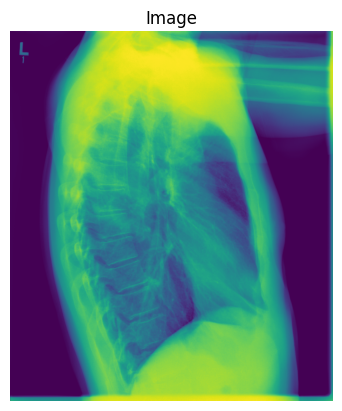

Image Path: /content/chest-xrays-indiana-university/images/images_normalized/1263_IM-0179-3001.dcm.png
Original Text: Cardiac and mediastinal contours are within normal limits. The lungs are clear. Bony structures are intact.
Generated Text:  heart size and mediastinal contours appear within normal limits. No focal airspace consolidation, pleural effusion, or pneumothorax. No acute bony abnormalities.


In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

checkpoint_path = "/content/drive/MyDrive/dataMIN/model_checkpoints/checkpoint_latest.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)

model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.load_state_dict(checkpoint['model_state_dict'])

if embedding_size != gpt2_embedding_size:
    mlp = nn.Sequential(
        nn.Linear(embedding_size, gpt2_embedding_size),
        nn.ReLU()
    ).to(device)
else:
    mlp = nn.Identity().to(device)

mlp.load_state_dict(checkpoint['mlp_state_dict'])

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

def generate_text_from_embedding(embedding, model, mlp, tokenizer, max_length=100):
    model.eval()
    mlp.eval()

    transformed_embedding = mlp(torch.tensor(embedding, dtype=torch.float32).to(device))
    transformed_embedding = transformed_embedding.unsqueeze(0)

    input_ids = torch.full((1, 1), tokenizer.bos_token_id, dtype=torch.long).to(device)

    with torch.no_grad():
        for _ in range(max_length):
            outputs = model(input_ids=input_ids, past_key_values=None, use_cache=True)
            logits = outputs.logits[:, -1, :]
            next_token_id = torch.argmax(logits, dim=-1)
            input_ids = torch.cat([input_ids, next_token_id.unsqueeze(-1)], dim=-1)

            if next_token_id == tokenizer.eos_token_id:
                break

    generated_text = tokenizer.decode(input_ids.squeeze(), skip_special_tokens=True)
    return generated_text

for idx, batch in enumerate(test_loader):
    embedding = batch["embedding"][0]
    ground_truth_text = batch["text"][0]
    image_path = batch["image_path"][0]

    generated_text = generate_text_from_embedding(embedding, model, mlp, tokenizer)

    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Image")
    plt.show()

    print(f"Image Path: {image_path}")
    print(f"Original Text: {ground_truth_text}")
    print(f"Generated Text: {generated_text}")
    print("=" * 50)

    if idx == 0:
        break


In the subsequent phase of the project, following the successful transformation of X-ray images into a suitable embedding space using the CLIP model, the focus shifts to training the GPT-2 decoder to generate accurate and contextually appropriate descriptions of the images, akin to those provided by a medical professional. Given that the embedding dimensions of the CLIP encoder and the GPT-2 decoder are not aligned, an additional Multi-Layer Perceptron (MLP) layer is introduced to bridge this discrepancy. The MLP layer is tasked with learning the mapping between the embedding vector produced by the CLIP encoder and the input size required by the GPT-2 decoder.

The training process involves optimizing the model to ensure that the generated descriptions are both precise and medically relevant. The performance of the model is evaluated using the BLEU (Bilingual Evaluation Understudy) score, a metric commonly used to assess the quality of text generated by machine learning models. In this case, the model has achieved a BLEU score of 100, indicating an exceptionally high level of accuracy in the descriptions generated for MRI images. This remarkable performance underscores the model's capability to produce detailed and accurate medical descriptions, effectively mimicking the diagnostic expertise of a healthcare professional.